In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
train = pd.read_csv("/Users/karnavivek/Food-Demand-Forecasting/Food Demand/data/train.csv")
meal_info = pd.read_csv("/Users/karnavivek/Food-Demand-Forecasting/Food Demand/data/meal_info.csv")
fulfilment_center_info = pd.read_csv("/Users/karnavivek/Food-Demand-Forecasting/Food Demand/data/fulfilment_center_info.csv")
test = pd.read_csv("/Users/karnavivek/Food-Demand-Forecasting/Food Demand/data/test.csv")

merge1 = pd.merge(train, fulfilment_center_info, how='left')
merge2 = pd.merge(merge1, meal_info, how='left')

merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']] = merge2[['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured']].astype('object')

df_weekly_orders = merge2.groupby(['week'])['num_orders'].sum().reset_index()
df_weekly_orders.set_index(df_weekly_orders['week'], inplace=True)
df_weekly_orders.drop(columns='week', inplace=True)

In [5]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [6]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

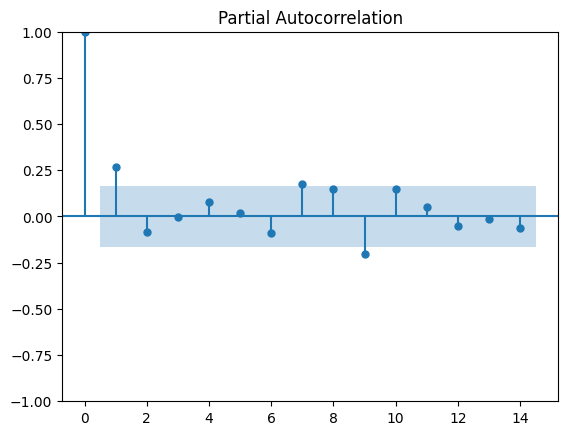

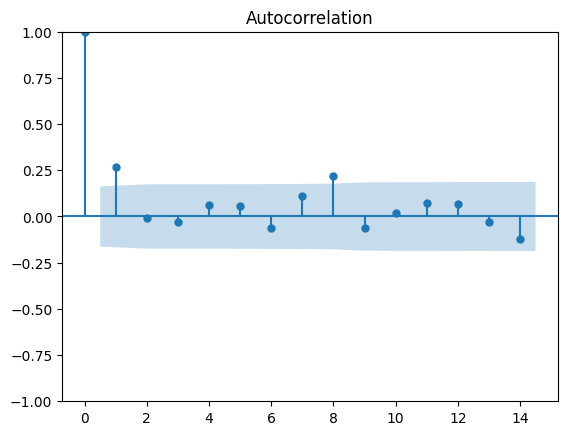

In [7]:
def plot_acf_pacf(y, lag):
    pacf = plot_pacf(y, lags=lag)
    acf = plot_acf(y, lags=lag)

plot_acf_pacf(df_weekly_orders['num_orders'], 14)

we can see that there is correlation of lag 1 in both, hence AR(1)& MA(1), but before this lets check if the Time Series is Stationary, Lets conduct Augmented Dickey-Fuller Test:

In [8]:
from statsmodels.tsa.stattools import adfuller

val_order_ = adfuller(df_weekly_orders['num_orders'], autolag='AIC')
print(f'T-stat: {val_order_[0]}')
print(f'P Value: {val_order_[1]}')
print(f'Lags: {val_order_[2]}')
print(f'Number of Observations used: {val_order_[3]}')
for key, val in val_order_[4].items():
    print(f'Critical Value at {key}: {val}\n')

if val_order_[1]>0.05:
    print('This Time Series Model is Non Stationary, may give bad predictions! :(\n')
else:
    print('This Time Series Model is Stationary, getting prediction is recommended! :)\n')

T-stat: -2.542865772667447
P Value: 0.10538983404031177
Lags: 9
Number of Observations used: 135
Critical Value at 1%: -3.479742586699182

Critical Value at 5%: -2.88319822181578

Critical Value at 10%: -2.578319684499314

This Time Series Model is Non Stationary, may give bad predictions! :(



In [9]:
'''We need to convert This NON STATIONARY TS into STATIONARY TS using FIRST ORDER DIFFERENCING'''

df_weekly_orders.head()

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675


In [10]:
df_weekly_orders.describe().round()

,num_orders
count,145.0
mean,824534.0
std,125670.0
min,380065.0
25%,745193.0
50%,809625.0
75%,892631.0
max,1303457.0


In [11]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


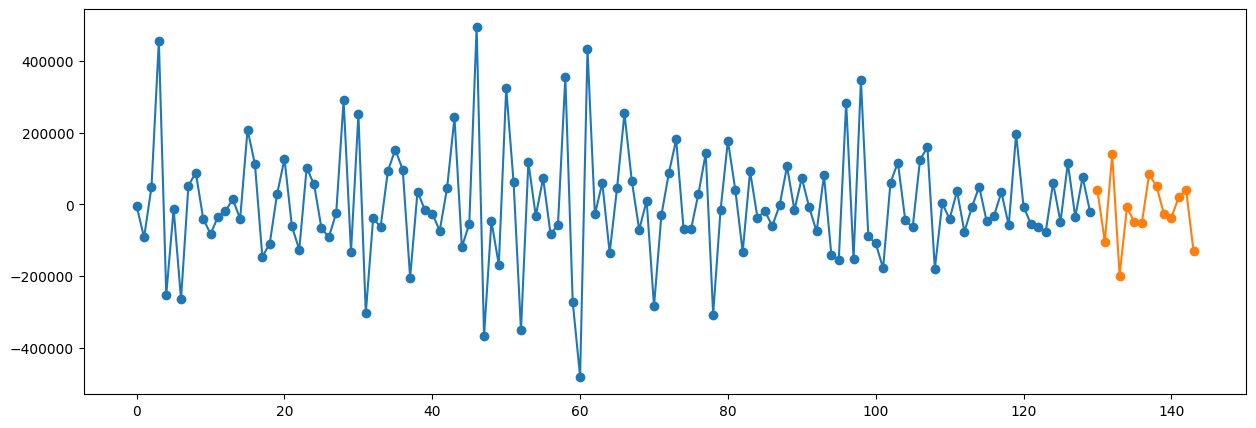

In [12]:
#performing differencing for converting non-stationary series into stationary time series

def fod(df, order=1):
    return df.diff(periods=order).dropna().reset_index(drop=True)

df_fod = fod(df_weekly_orders, 1)


# orders_diff = df_weekly_orders['num_orders'].diff().dropna() #we can add params like periods=1, axis=0 (rows default)
train_orders = df_fod[:130]
val_orders = df_fod[130:]

plt.figure(figsize=(15,5))
# plt.plot(df_weekly_orders['num_orders'], marker='o')
plt.plot(train_orders, marker='o')
plt.plot(val_orders, marker='o')

plt.show()

Let's Check the stationarity again by performing ADF Test again

In [13]:
from statsmodels.tsa.stattools import adfuller

val_order_ = adfuller(train_orders, autolag='AIC')
print(f'T-stat: {val_order_[0]}')
print(f'P Value: {val_order_[1]}')
print(f'Lags: {val_order_[2]}')
print(f'Number of Observations used: {val_order_[3]}')
for key, val in val_order_[4].items():
    print(f'Critical Value at {key}: {val}\n')

if val_order_[1]>0.05:
    print('This Time Series Model is Non Stationary, may give bad predictions! :(\n')
else:
    print('This Time Series Model is Stationary, getting prediction is recommended! :)\n')

T-stat: -6.337555859166213
P Value: 2.8062644671857925e-08
Lags: 8
Number of Observations used: 121
Critical Value at 1%: -3.485585145896754

Critical Value at 5%: -2.885738566292665

Critical Value at 10%: -2.5796759080663887

This Time Series Model is Stationary, getting prediction is recommended! :)



A simple First order differencing gave us P-value << 0.05, Hence we will move forward with our ARIMA Modelling, <br>

Now, let's check (p) & (q) value by ACF & PACF

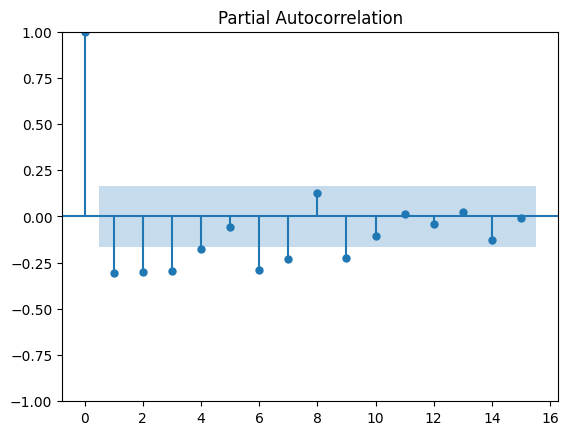

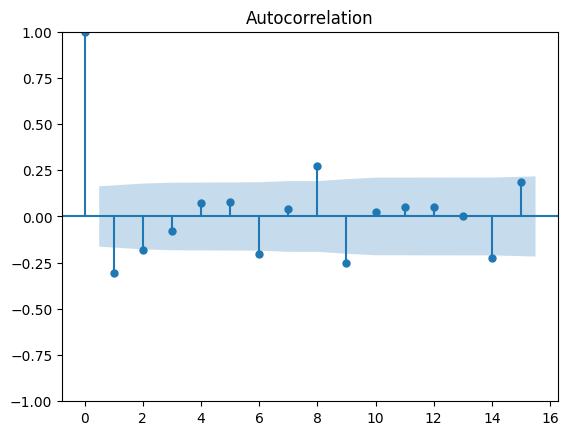

In [15]:
plot_acf_pacf(df_fod, 15)

By these 2 graphs, we know that, ACF -> q = 2 -> MA(2) | PACF -> p = 4 -> AR(4)<br>
Hence, $ARMA(4,2)$

In [16]:
model = ARIMA(train_orders, order=(4,0,2))
model_fit = model.fit()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [221]:
diff_forecast =  model_fit.get_forecast(steps=14) 
#get_forecast is an object which has all the info about the data, we need to take out forecast values
forecast_values = diff_forecast.predicted_mean
print(forecast_values)

130   -20555.420901
131     6390.224520
132    -6411.754767
133    10614.942653
134    -6949.326993
135     8434.504124
136    -6668.763218
137     7834.444790
138    -5877.683917
139     7247.112156
140    -5282.906716
141     6661.560475
142    -4739.552803
143     6139.579485
Name: predicted_mean, dtype: float64


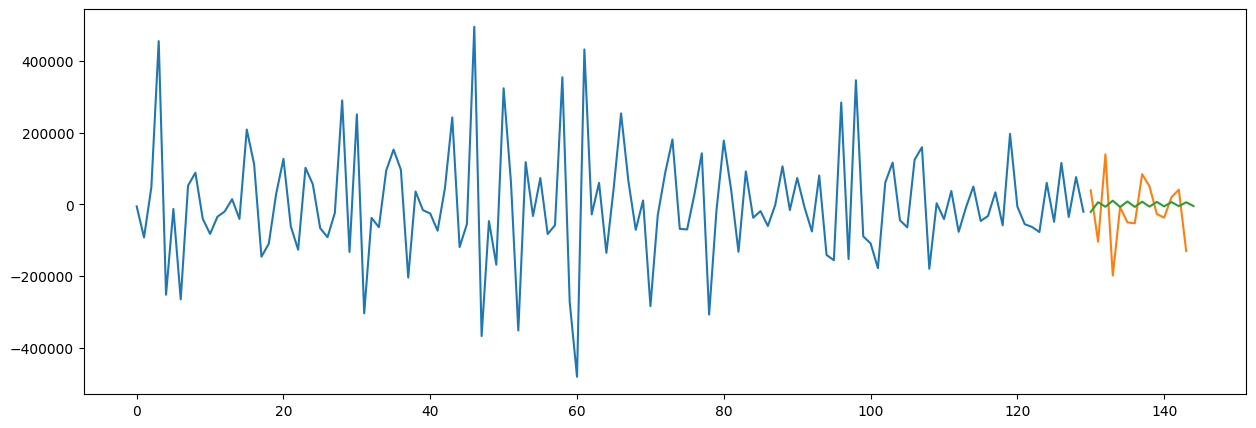

In [218]:
plt.figure(figsize=(15,5))
plt.plot(train_orders)
plt.plot(val_orders)
plt.plot(forecast_values)
plt.show()

#### Undo-Transformation to original data

In [222]:
val_orders

,num_orders
130,39421.0
131,-103791.0
132,139489.0
133,-197966.0
134,-7483.0
135,-49883.0
136,-52397.0
137,84592.0
138,50754.0
139,-26449.0


In [225]:
mse = mean_squared_error(val_orders, forecast_values)
mse

8419585272.889681

In [228]:
def inverse_fod(differenced_values, first_original_value):
    original_values = [first_original_value]
    
    for diff_value in differenced_values:
        # Add differenced value to the previous original value
        next_value = diff_value + original_values[-1]
        original_values.append(next_value)
    
    return original_values

inverse_fod(forecast_values, val_orders)

[     num_orders
 130     39421.0
 131   -103791.0
 132    139489.0
 133   -197966.0
 134     -7483.0
 135    -49883.0
 136    -52397.0
 137     84592.0
 138     50754.0
 139    -26449.0
 140    -36579.0
 141     20265.0
 142     41271.0
 143   -129271.0,
         num_orders
 130   18865.579099
 131 -124346.420901
 132  118933.579099
 133 -218521.420901
 134  -28038.420901
 135  -70438.420901
 136  -72952.420901
 137   64036.579099
 138   30198.579099
 139  -47004.420901
 140  -57134.420901
 141    -290.420901
 142   20715.579099
 143 -149826.420901,
        num_orders
 130   25255.80362
 131 -117956.19638
 132  125323.80362
 133 -212131.19638
 134  -21648.19638
 135  -64048.19638
 136  -66562.19638
 137   70426.80362
 138   36588.80362
 139  -40614.19638
 140  -50744.19638
 141    6099.80362
 142   27105.80362
 143 -143436.19638,
         num_orders
 130   18844.048853
 131 -124367.951147
 132  118912.048853
 133 -218542.951147
 134  -28059.951147
 135  -70459.951147
 136  -72973.9511

In [226]:
# Assuming your model predicts the next differenced values
# predicted_diffs = model.predict(steps=3)  # e.g., [50000, 30000, 20000]

# Get the last value from your original time series
last_original_value = df_weekly_orders.iloc[-1]['num_orders']

# Convert predictions back to original scale
# predicted_original = inverse_fod(forecast_values, last_original_value)

# predicted_original will contain: [last_original_value, forecast1, forecast2, forecast3]
# The first element is your starting point, and the rest are your forecasts


671926

In [52]:
df_weekly_orders

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


In [146]:
def fod(df, order=1):
    df_fod = []
    for i in range(1, len(df)):
        new = (df.iloc[i] - df.iloc[i-order]).values[0]
        df_fod.append(new)
    return pd.DataFrame(df_fod)

df_fod = fod(df_weekly_orders, 1)
df_fod

,0
0,-5177
1,-91822
2,48267
3,455146
4,-251387
...,...
139,-26449
140,-36579
141,20265
142,41271


In [152]:
def fod(df, order=1):
    return df.diff(periods=order).dropna().reset_index(drop=True)

df_fod = fod(df_weekly_orders, 1)
df_fod

,num_orders
0,-5177.0
1,-91822.0
2,48267.0
3,455146.0
4,-251387.0
...,...
139,-26449.0
140,-36579.0
141,20265.0
142,41271.0


In [206]:
df_fod

,num_orders
0,-5177.0
1,-91822.0
2,48267.0
3,455146.0
4,-251387.0
...,...
139,-26449.0
140,-36579.0
141,20265.0
142,41271.0


In [83]:
orders_diff.iloc[0] + df_weekly_orders['num_orders'].iloc[1]

781907.0

In [69]:
df_weekly_orders['num_orders'].iloc[1]

787084

In [149]:
def fod_reverse(fod_data, original_data, order=1):
    df_restored = []
    for i in range(0, range(fod_data)):
        q = fod_data.iloc[i] + original_data.iloc[i+1]
        df_restored.append(q)
    return df_restored

fod_reverse(df_fod, df_weekly_orders, 1)


TypeError: 'DataFrame' object cannot be interpreted as an integer

In [41]:
df_weekly_orders['num_orders'] + df_fod.shift(-1)

week
1            NaN
2       695262.0
3       743529.0
4      1198675.0
5       947288.0
         ...    
141     739661.0
142     759926.0
143     801197.0
144     671926.0
145          NaN
Name: num_orders, Length: 145, dtype: float64

In [40]:
x = []
diff_results = df_weekly_orders['num_orders'][:] + df_fod[:].shift(-1)
x.append(diff_results)
diff_restored = pd.concat(x, axis=1)

diff_restored

,num_orders
week,
1,NaN
2,695262.0
3,743529.0
4,1198675.0
5,947288.0
...,...
141,739661.0
142,759926.0
143,801197.0


In [39]:
diff_results

,num_orders,2,3,4,5,6,7,8,9,10,...,136,137,138,139,140,141,142,143,144,145
week,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
